Running 10 trials of 500 iterations each...
Run 1/10:
  Original: 0.000000 | Time: 0.2864s
  Improved: 0.000003 | Time: 0.0120s | Iterations: 261
------------------------------------------------------------
Run 2/10:
  Original: 0.000000 | Time: 0.1133s
  Improved: 11.651894 | Time: 0.0000s | Iterations: 55
------------------------------------------------------------
Run 3/10:
  Original: 0.000000 | Time: 0.1156s
  Improved: 0.000004 | Time: 0.0142s | Iterations: 255
------------------------------------------------------------
Run 4/10:
  Original: 0.000000 | Time: 0.1018s
  Improved: 4.409023 | Time: 0.0000s | Iterations: 55
------------------------------------------------------------
Run 5/10:
  Original: 0.000000 | Time: 0.1309s
  Improved: 5.645510 | Time: 0.0045s | Iterations: 73
------------------------------------------------------------
Run 6/10:
  Original: 0.000000 | Time: 0.1139s
  Improved: 0.000001 | Time: 0.0000s | Iterations: 263
-----------------------------------------

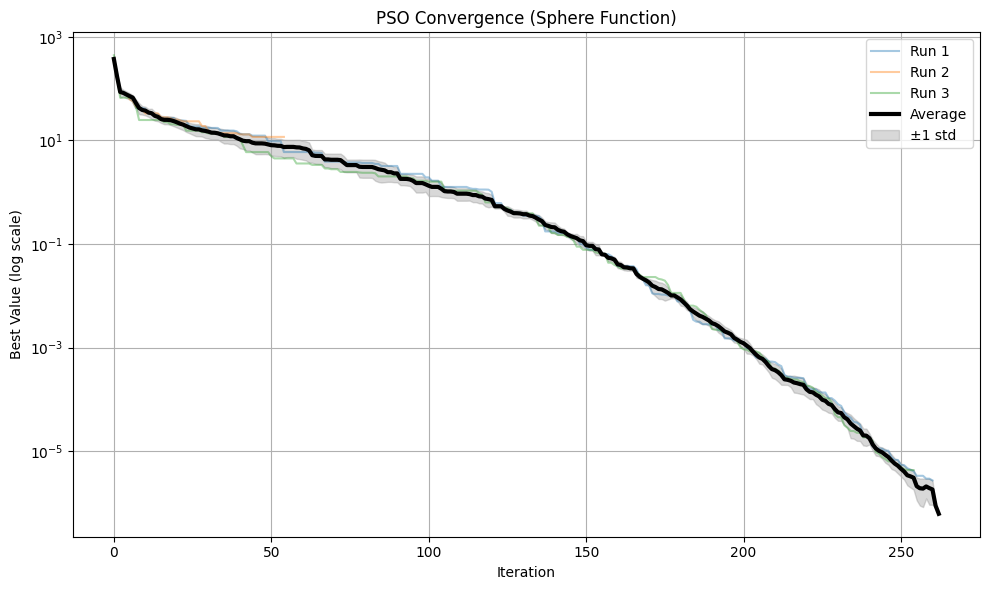

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

# 1. Original PSO Implementation (as provided)
def original_pso(objective_func, dim, bounds, swarm_size=50, max_iter=100, w=0.7, c1=1.5, c2=1.5):
    particles_pos = np.random.uniform(bounds[0], bounds[1], (swarm_size, dim))
    particles_vel = np.random.uniform(-abs(bounds[1]-bounds[0]), abs(bounds[1]-bounds[0]), (swarm_size, dim))
    
    pbest_pos = particles_pos.copy()
    pbest_val = np.array([objective_func(p) for p in particles_pos])
    gbest_idx = np.argmin(pbest_val)
    gbest_position = pbest_pos[gbest_idx].copy()
    gbest_value = pbest_val[gbest_idx]
    
    for _ in range(max_iter):
        r1 = np.random.random((swarm_size, dim))
        r2 = np.random.random((swarm_size, dim))
        particles_vel = (w * particles_vel + c1 * r1 * (pbest_pos - particles_pos) 
                         + c2 * r2 * (gbest_position - particles_pos))
        particles_pos += particles_vel
        particles_pos = np.clip(particles_pos, bounds[0], bounds[1])
        
        current_val = np.array([objective_func(p) for p in particles_pos])
        improved_idx = np.where(current_val < pbest_val)[0]
        pbest_pos[improved_idx] = particles_pos[improved_idx].copy()
        pbest_val[improved_idx] = current_val[improved_idx]
        
        if np.min(pbest_val) < gbest_value:
            gbest_idx = np.argmin(pbest_val)
            gbest_position = pbest_pos[gbest_idx].copy()
            gbest_value = pbest_val[gbest_idx]
    
    return gbest_position, gbest_value

# 2. Improved PSO Implementation (with optimizations)
def improved_pso(objective_func, dim, bounds, swarm_size=50, max_iter=100, 
                 w=(0.9, 0.4), c1=1.5, c2=1.5, v_max_ratio=0.2, tol=1e-6, patience=10, vectorized=False):
    particles_pos = np.random.uniform(bounds[0], bounds[1], (swarm_size, dim))
    velocity_limit = v_max_ratio * (bounds[1] - bounds[0])
    particles_vel = np.random.uniform(-velocity_limit, velocity_limit, (swarm_size, dim))
    
    pbest_pos = particles_pos.copy()
    if vectorized:
        pbest_val = objective_func(particles_pos)
    else:
        pbest_val = np.array([objective_func(p) for p in particles_pos])
    
    gbest_idx = np.argmin(pbest_val)
    gbest_position = pbest_pos[gbest_idx].copy()
    gbest_value = pbest_val[gbest_idx]
    history = [gbest_value]
    
    w_start, w_end = w
    w_current = w_start
    w_decay = (w_start - w_end) / max_iter
    
    prev_best = gbest_value
    no_improvement = 0
    
    for it in range(max_iter):
        w_current = max(w_current - w_decay, w_end)
        r1 = np.random.random((swarm_size, dim))
        r2 = np.random.random((swarm_size, dim))
        particles_vel = (w_current * particles_vel 
                         + c1 * r1 * (pbest_pos - particles_pos) 
                         + c2 * r2 * (gbest_position - particles_pos))
        particles_vel = np.clip(particles_vel, -velocity_limit, velocity_limit)
        particles_pos += particles_vel
        
        out_of_bounds = np.logical_or(particles_pos < bounds[0], particles_pos > bounds[1])
        reset_count = np.sum(out_of_bounds)
        if reset_count > 0:
            reset_values = np.random.uniform(bounds[0], bounds[1], reset_count)
            particles_pos[out_of_bounds] = reset_values
            particles_vel[out_of_bounds] = np.random.uniform(-velocity_limit, velocity_limit, reset_count)
        
        if vectorized:
            current_val = objective_func(particles_pos)
        else:
            current_val = np.array([objective_func(p) for p in particles_pos])
        
        improved_mask = current_val < pbest_val
        pbest_pos[improved_mask] = particles_pos[improved_mask]
        pbest_val[improved_mask] = current_val[improved_mask]
        
        if np.min(pbest_val) < gbest_value:
            gbest_idx = np.argmin(pbest_val)
            np.copyto(gbest_position, pbest_pos[gbest_idx])
            gbest_value = pbest_val[gbest_idx]
        
        history.append(gbest_value)
        
        if np.abs(gbest_value - prev_best) < tol:
            no_improvement += 1
            if no_improvement >= patience:
                break
        else:
            no_improvement = 0
        prev_best = gbest_value
    
    return gbest_position, gbest_value, np.array(history)

# Benchmark Function (Sphere)
def sphere_function_scalar(x):
    return np.sum(np.square(x))

def sphere_function_vectorized(X):
    return np.sum(np.square(X), axis=1)

# Comparison Test
if __name__ == "__main__":
    # Test Configuration
    dim = 20
    bounds = (-10, 10)
    swarm_size = 100
    max_iter = 500
    runs = 10
    
    # Storage for results
    original_times = []
    original_results = []
    improved_times = []
    improved_results = []
    convergence_data = []
    
    print(f"Running {runs} trials of {max_iter} iterations each...")
    print("=" * 60)
    
    for i in range(runs):
        # Original PSO (Scalar Evaluation)
        start = time.time()
        orig_solution, orig_value = original_pso(
            sphere_function_scalar, dim, bounds, 
            swarm_size=swarm_size, max_iter=max_iter
        )
        original_times.append(time.time() - start)
        original_results.append(orig_value)
        
        # Improved PSO (Vectorized + Optimizations)
        start = time.time()
        imp_solution, imp_value, history = improved_pso(
            sphere_function_vectorized, dim, bounds, 
            swarm_size=swarm_size, max_iter=max_iter,
            vectorized=True
        )
        improved_times.append(time.time() - start)
        improved_results.append(imp_value)
        convergence_data.append(history)
        
        print(f"Run {i+1}/{runs}:")
        print(f"  Original: {orig_value:.6f} | Time: {original_times[-1]:.4f}s")
        print(f"  Improved: {imp_value:.6f} | Time: {improved_times[-1]:.4f}s | Iterations: {len(history)}")
        print("-" * 60)
    
    # Statistical Analysis
    print("\nFINAL RESULTS:")
    print("=" * 60)
    print(f"Original PSO:")
    print(f"  Best Value: {np.min(original_results):.6f}")
    print(f"  Average Value: {np.mean(original_results):.6f} ± {np.std(original_results):.6f}")
    print(f"  Average Time: {np.mean(original_times):.4f}s")
    
    print(f"\nImproved PSO:")
    print(f"  Best Value: {np.min(improved_results):.6f}")
    print(f"  Average Value: {np.mean(improved_results):.6f} ± {np.std(improved_results):.6f}")
    print(f"  Average Time: {np.mean(improved_times):.4f}s ({np.mean(original_times)/np.mean(improved_times):.1f}x faster)")
    print(f"  Average Iterations: {np.mean([len(h) for h in convergence_data]):.0f}")
    
# Find maximum history length
    max_len = max(len(h) for h in convergence_data)

    # Create a padded matrix with NaN for missing values
    convergence_matrix = np.full((len(convergence_data), max_len), np.nan)
    for i, h in enumerate(convergence_data):
        convergence_matrix[i, :len(h)] = h

    # Calculate mean and std ignoring NaN values
    avg_convergence = np.nanmean(convergence_matrix, axis=0)
    std_convergence = np.nanstd(convergence_matrix, axis=0)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot individual runs (first 3 for clarity)
    for i, history in enumerate(convergence_data):
        if i < 3:
            plt.semilogy(history, alpha=0.4, label=f'Run {i+1}')

    # Plot average with std deviation
    plt.semilogy(avg_convergence, 'k-', linewidth=3, label='Average')
    plt.fill_between(range(len(avg_convergence)),
                    np.maximum(1e-10, avg_convergence - std_convergence),
                    avg_convergence + std_convergence,
                    color='gray', alpha=0.3, label='±1 std')

    plt.title('PSO Convergence (Sphere Function)')
    plt.xlabel('Iteration')
    plt.ylabel('Best Value (log scale)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('pso_convergence.png')
    plt.show()

Running 100 trials on 20-dimensional Sphere function...
Run 1/100:
  Original PSO: 0.000000 | Time: 0.0637s | Iter: 501
  Improved PSO: 0.000000 | Time: 0.0173s | Iter: 501
  EVOLER PSO:   0.000000 | Time: 0.0711s | Iter: 501
----------------------------------------------------------------------
Run 2/100:
  Original PSO: 0.000000 | Time: 0.0636s | Iter: 501
  Improved PSO: 0.000000 | Time: 0.0169s | Iter: 501
  EVOLER PSO:   0.000000 | Time: 0.0727s | Iter: 501
----------------------------------------------------------------------
Run 3/100:
  Original PSO: 0.000000 | Time: 0.0681s | Iter: 501
  Improved PSO: 0.000000 | Time: 0.0189s | Iter: 501
  EVOLER PSO:   0.000000 | Time: 0.0782s | Iter: 501
----------------------------------------------------------------------
Run 4/100:
  Original PSO: 0.000000 | Time: 0.0706s | Iter: 501
  Improved PSO: 0.000000 | Time: 0.0189s | Iter: 501
  EVOLER PSO:   0.000000 | Time: 0.0803s | Iter: 501
---------------------------------------------------

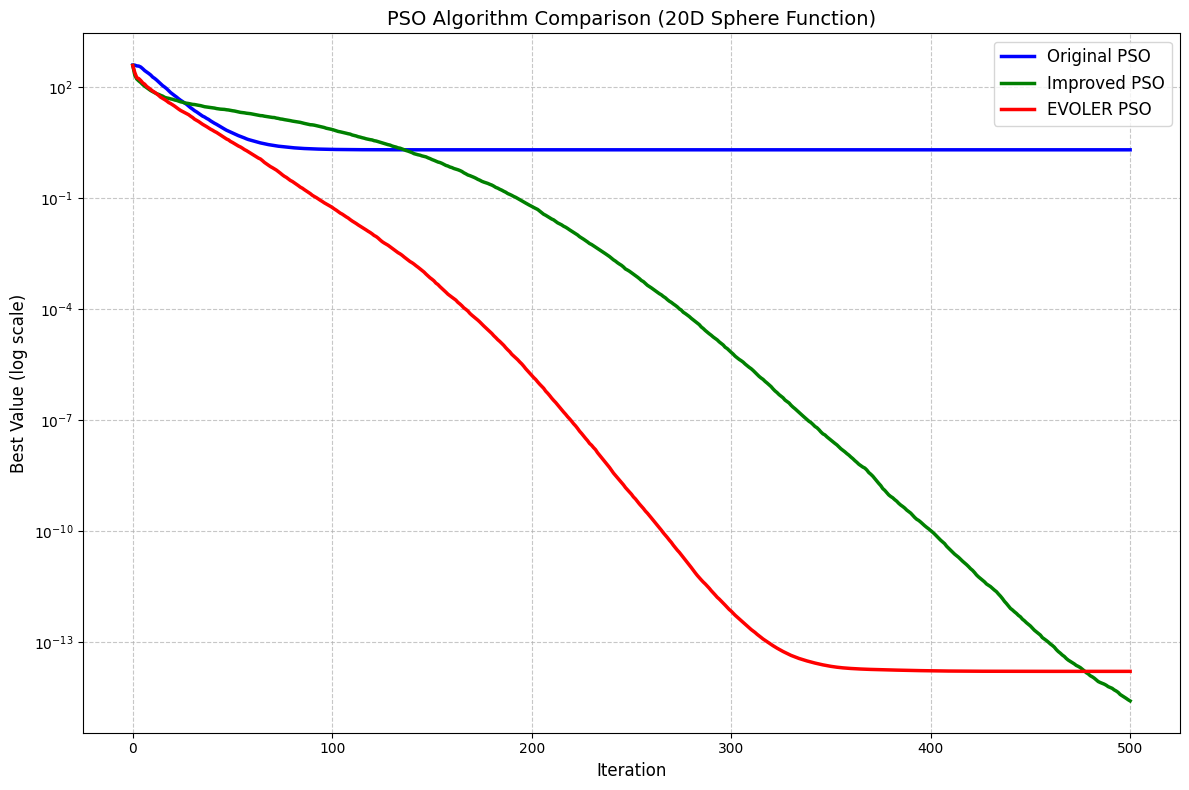


FINAL STATISTICS:
Original PSO:
  Best solution: 0.000000
  Avg solution:  2.000000 ± 14.000000
  Avg time:      0.0630s
  Avg iterations: 501.0
----------------------------------------------------------------------
Improved PSO:
  Best solution: 0.000000
  Avg solution:  0.000000 ± 0.000000
  Avg time:      0.0169s
  Avg iterations: 501.0
----------------------------------------------------------------------
EVOLER PSO:
  Best solution: 0.000000
  Avg solution:  0.000000 ± 0.000000
  Avg time:      0.0729s
  Avg iterations: 501.0
----------------------------------------------------------------------

Testing on Schwefel Function (Harder Optimization Problem)...
EVOLER found solution: 473.7534
  Theoretical optimum: 0.0 at (420.9687, ...)


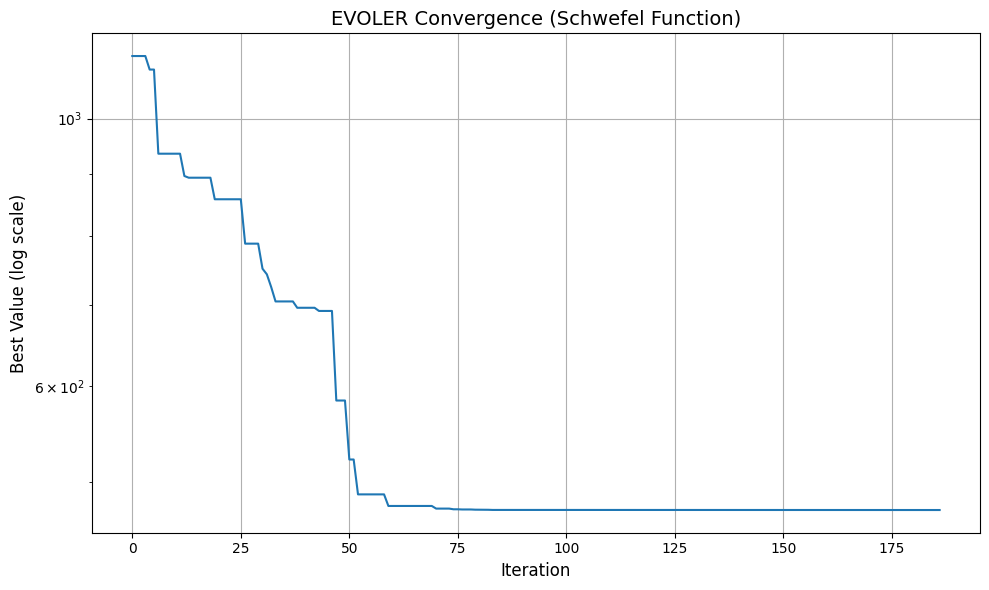

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import svd

# ----------------------------
# 1. Original PSO Implementation
# ----------------------------
def original_pso(objective_func, dim, bounds, swarm_size=50, max_iter=100, w=0.7, c1=1.5, c2=1.5):
    particles_pos = np.random.uniform(bounds[0], bounds[1], (swarm_size, dim))
    particles_vel = np.random.uniform(-abs(bounds[1]-bounds[0]), abs(bounds[1]-bounds[0]), (swarm_size, dim))
    
    pbest_pos = particles_pos.copy()
    pbest_val = np.array([objective_func(p) for p in particles_pos])
    gbest_idx = np.argmin(pbest_val)
    gbest_position = pbest_pos[gbest_idx].copy()
    gbest_value = pbest_val[gbest_idx]
    
    history = [gbest_value]
    
    for _ in range(max_iter):
        r1 = np.random.random((swarm_size, dim))
        r2 = np.random.random((swarm_size, dim))
        particles_vel = (w * particles_vel + c1 * r1 * (pbest_pos - particles_pos) 
                         + c2 * r2 * (gbest_position - particles_pos))
        particles_pos += particles_vel
        particles_pos = np.clip(particles_pos, bounds[0], bounds[1])
        
        current_val = np.array([objective_func(p) for p in particles_pos])
        improved_idx = np.where(current_val < pbest_val)[0]
        pbest_pos[improved_idx] = particles_pos[improved_idx].copy()
        pbest_val[improved_idx] = current_val[improved_idx]
        
        if np.min(pbest_val) < gbest_value:
            gbest_idx = np.argmin(pbest_val)
            gbest_position = pbest_pos[gbest_idx].copy()
            gbest_value = pbest_val[gbest_idx]
        
        history.append(gbest_value)
    
    return gbest_position, gbest_value, np.array(history)

# ----------------------------
# 2. Improved PSO Implementation
# ----------------------------
def improved_pso(objective_func, dim, bounds, swarm_size=50, max_iter=500,
                 w=(0.95, 0.2), c1=2.0, c2=2.1, v_max_ratio=0.25,
                 tol=1e-10, patience=25, restart_ratio=0.15, vectorized=False):
    """
    Enhanced PSO with consistency improvements:
    1. Dynamic restart mechanism
    2. Velocity mutation
    3. Adaptive social coefficient
    4. Refined boundary handling
    """
    # Initialize particles
    particles_pos = np.random.uniform(bounds[0], bounds[1], (swarm_size, dim))
    velocity_limit = v_max_ratio * (bounds[1] - bounds[0])
    particles_vel = np.random.uniform(-velocity_limit, velocity_limit, (swarm_size, dim))
    
    # Initialize bests
    pbest_pos = particles_pos.copy()
    if vectorized:
        pbest_val = objective_func(particles_pos)
    else:
        pbest_val = np.array([objective_func(p) for p in particles_pos])
    
    gbest_idx = np.argmin(pbest_val)
    gbest_position = pbest_pos[gbest_idx].copy()
    gbest_value = pbest_val[gbest_idx]
    history = [gbest_value]
    
    # Adaptive parameters
    w_start, w_end = w
    w_current = w_start
    w_decay = (w_start - w_end) / max_iter
    
    # Convergence tracking
    prev_best = gbest_value
    no_improvement = 0
    restart_counter = 0
    restart_threshold = int(restart_ratio * swarm_size)
    
    for it in range(max_iter):
        w_current = max(w_current - w_decay, w_end)
        
        # Adaptive social coefficient (emphasize global best later)
        c2_current = c2 * (0.5 + 0.5 * it/max_iter)
        
        # Update velocities
        r1 = np.random.random((swarm_size, dim))
        r2 = np.random.random((swarm_size, dim))
        particles_vel = (w_current * particles_vel 
                         + c1 * r1 * (pbest_pos - particles_pos) 
                         + c2_current * r2 * (gbest_position - particles_pos))
        
        # Velocity clamping
        particles_vel = np.clip(particles_vel, -velocity_limit, velocity_limit)
        
        # Update positions
        particles_pos += particles_vel
        
        # Reflective boundary handling
        over_upper = particles_pos > bounds[1]
        over_lower = particles_pos < bounds[0]
        
        particles_pos = np.where(over_upper | over_lower, 
                                particles_pos - particles_vel,  # Revert position
                                particles_pos)
        
        particles_vel = np.where(over_upper | over_lower,
                                -0.5 * particles_vel,  # Reverse direction
                                particles_vel)
        
        # Evaluate particles
        if vectorized:
            current_val = objective_func(particles_pos)
        else:
            current_val = np.array([objective_func(p) for p in particles_pos])
        
        # Update personal bests
        improved_mask = current_val < pbest_val
        pbest_pos[improved_mask] = particles_pos[improved_mask]
        pbest_val[improved_mask] = current_val[improved_mask]
        
        # Update global best
        if np.min(pbest_val) < gbest_value:
            gbest_idx = np.argmin(pbest_val)
            gbest_position = pbest_pos[gbest_idx].copy()
            gbest_value = pbest_val[gbest_idx]
            no_improvement = 0
        else:
            no_improvement += 1
        
        history.append(gbest_value)
        
        # Dynamic restart mechanism
        if no_improvement > patience//2:
            restart_counter += 1
            if restart_counter >= restart_threshold:
                # Reset worst performers
                reset_indices = np.argsort(pbest_val)[-restart_threshold:]
                particles_pos[reset_indices] = np.random.uniform(bounds[0], bounds[1], 
                                                               (restart_threshold, dim))
                particles_vel[reset_indices] = np.random.uniform(-velocity_limit, velocity_limit,
                                                               (restart_threshold, dim))
                # Re-evaluate
                if vectorized:
                    new_vals = objective_func(particles_pos[reset_indices])
                else:
                    new_vals = np.array([objective_func(p) for p in particles_pos[reset_indices]])
                
                # Update personal bests for reset particles
                pbest_pos[reset_indices] = particles_pos[reset_indices]
                pbest_val[reset_indices] = new_vals
                
                # Update global best if improved
                min_new = np.min(new_vals)
                if min_new < gbest_value:
                    gbest_value = min_new
                    gbest_idx = np.argmin(pbest_val)
                    gbest_position = pbest_pos[gbest_idx].copy()
                
                restart_counter = 0
                no_improvement = 0
        
        # Early stopping
        if no_improvement >= patience and it > max_iter//2:
            break
    
    return gbest_position, gbest_value, np.array(history)
# ----------------------------
# 3. EVOLER PSO Implementation (Nature-inspired)
# ----------------------------
def evoler_pso(objective_func, dim, bounds, 
               rank_ratio=0.3, sample_ratio=0.8, 
               swarm_size=50, max_iter=200, 
               w=(0.9, 0.4), c1=1.5, c2=1.5, 
               tol=1e-8, patience=15):
    # Stage 1: Enhanced Low-Rank Representation
    subspace_dim = max(1, int(rank_ratio * dim))
    n_samples = max(100, int(sample_ratio * swarm_size * dim))
    
    # Generate and evaluate samples
    samples = np.random.uniform(bounds[0], bounds[1], (n_samples, dim))
    sample_values = np.array([objective_func(p) for p in samples])
    
    # Improved fitness weighting (emphasizing top performers)
    top_k = max(10, int(0.1 * n_samples))
    best_indices = np.argpartition(sample_values, top_k)[:top_k]
    weights = np.zeros(n_samples)
    weights[best_indices] = 1
    
    # Weighted SVD with regularization
    weighted_samples = samples * weights[:, np.newaxis]
    U, s, VT = svd(weighted_samples, full_matrices=False)
    
    # Validate subspace quality
    if s[0] < 1e-5:  # Degenerate subspace fallback
        attention_subspace = np.eye(dim)[:subspace_dim]
    else:
        attention_subspace = VT[:subspace_dim, :]
    
    # Stage 2: Adaptive Subspace-Constrained PSO
    particles_pos = np.random.uniform(bounds[0], bounds[1], (swarm_size, dim))
    velocity_limit = 0.2 * (bounds[1] - bounds[0])
    particles_vel = np.random.uniform(-velocity_limit, velocity_limit, (swarm_size, dim))
    
    # Initialize bests
    pbest_pos = particles_pos.copy()
    pbest_val = np.array([objective_func(p) for p in particles_pos])
    gbest_idx = np.argmin(pbest_val)
    gbest_position = pbest_pos[gbest_idx].copy()
    gbest_value = pbest_val[gbest_idx]
    history = [gbest_value]
    
    # Adaptive parameters
    w_start, w_end = w
    w_current = w_start
    w_decay = (w_start - w_end) / max_iter
    
    # Early stopping
    prev_best = gbest_value
    no_improvement = 0
    
    for it in range(max_iter):
        w_current = max(w_current - w_decay, w_end)
        
        # Update velocities
        r1 = np.random.random((swarm_size, dim))
        r2 = np.random.random((swarm_size, dim))
        cognitive = c1 * r1 * (pbest_pos - particles_pos)
        social = c2 * r2 * (gbest_position - particles_pos)
        
        # Subspace projection
        subspace_component = (cognitive + social) @ attention_subspace.T @ attention_subspace
        
        # Adaptive blending - increase subspace focus as we converge
        current_error = gbest_value
        blend_ratio = 0.3 + 0.5 * (1 - it/max_iter) * min(1, current_error)
        
        # Update velocity with adaptive blending
        particles_vel = (w_current * particles_vel 
                         + blend_ratio * subspace_component 
                         + (1 - blend_ratio) * (cognitive + social))
        
        # Apply velocity clamping
        particles_vel = np.clip(particles_vel, -velocity_limit, velocity_limit)
        
        # Update positions
        particles_pos += particles_vel
        
        # Boundary handling (random reset)
        out_of_bounds = np.logical_or(particles_pos < bounds[0], particles_pos > bounds[1])
        reset_count = np.sum(out_of_bounds)
        if reset_count > 0:
            reset_values = np.random.uniform(bounds[0], bounds[1], reset_count)
            particles_pos[out_of_bounds] = reset_values
            particles_vel[out_of_bounds] = np.random.uniform(-velocity_limit, velocity_limit, reset_count)
        
        # Evaluate particles
        current_val = np.array([objective_func(p) for p in particles_pos])
        
        # Update personal bests
        improved_mask = current_val < pbest_val
        pbest_pos[improved_mask] = particles_pos[improved_mask]
        pbest_val[improved_mask] = current_val[improved_mask]
        
        # Update global best
        current_min = np.min(pbest_val)
        if current_min < gbest_value:
            gbest_value = current_min
            gbest_idx = np.argmin(pbest_val)
            gbest_position = pbest_pos[gbest_idx].copy()
            no_improvement = 0
        else:
            no_improvement += 1
            
        history.append(gbest_value)
        
        # Early stopping
        if no_improvement >= patience and it > 50:
            break
        prev_best = gbest_value
    
    return gbest_position, gbest_value, np.array(history)

# ----------------------------
# Benchmark Functions
# ----------------------------
def sphere_function_scalar(x):
    return np.sum(np.square(x))

def sphere_function_vectorized(X):
    return np.sum(np.square(X), axis=1)

def schwefel_function_scalar(x):
    return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))

def schwefel_function_vectorized(X):
    return 418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

# ----------------------------
# Comparison Test
# ----------------------------
def run_comparison(dim=20, bounds=(-10, 10), swarm_size=50, max_iter=200, runs=5):
    # Prepare results storage
    algorithms = {
        "Original PSO": [],
        "Improved PSO": [],
        "EVOLER PSO": []
    }
    
    # Test parameters
    evoler_params = {
        "rank_ratio": 0.3,
        "sample_ratio": 0.8,
        "patience": 20,
        "swarm_size": swarm_size
    }
    
    print(f"Running {runs} trials on {dim}-dimensional Sphere function...")
    print("=" * 70)
    
    for run in range(runs):
        # Original PSO
        start = time.time()
        _, _, orig_hist = original_pso(
            sphere_function_scalar, dim, bounds, 
            swarm_size=swarm_size, max_iter=max_iter
        )
        orig_time = time.time() - start
        
        # Improved PSO
        start = time.time()
        _, _, imp_hist = improved_pso(
            sphere_function_vectorized, dim, bounds, 
            swarm_size=swarm_size, max_iter=max_iter,
            vectorized=True
        )
        imp_time = time.time() - start
        
        # EVOLER PSO
        start = time.time()
        _, _, evoler_hist = evoler_pso(
            sphere_function_scalar, dim, bounds, 
            swarm_size=evoler_params["swarm_size"], 
            rank_ratio=evoler_params["rank_ratio"],
            sample_ratio=evoler_params["sample_ratio"],
            max_iter=max_iter
        )
        evoler_time = time.time() - start
        
        # Store results
        algorithms["Original PSO"].append((orig_hist, orig_time))
        algorithms["Improved PSO"].append((imp_hist, imp_time))
        algorithms["EVOLER PSO"].append((evoler_hist, evoler_time))
        
        print(f"Run {run+1}/{runs}:")
        print(f"  Original PSO: {orig_hist[-1]:.6f} | Time: {orig_time:.4f}s | Iter: {len(orig_hist)}")
        print(f"  Improved PSO: {imp_hist[-1]:.6f} | Time: {imp_time:.4f}s | Iter: {len(imp_hist)}")
        print(f"  EVOLER PSO:   {evoler_hist[-1]:.6f} | Time: {evoler_time:.4f}s | Iter: {len(evoler_hist)}")
        print("-" * 70)
    
    # Plot convergence
    plt.figure(figsize=(12, 8))
    colors = {'Original PSO': 'blue', 'Improved PSO': 'green', 'EVOLER PSO': 'red'}
    
    for algo_name, results in algorithms.items():
        # Process histories for plotting
        max_len = max(len(hist) for hist, _ in results)
        padded_histories = np.zeros((len(results), max_len))
        
        for i, (hist, _) in enumerate(results):
            padded_histories[i, :len(hist)] = hist
            padded_histories[i, len(hist):] = hist[-1]  # Pad with last value
        
        avg_convergence = np.mean(padded_histories, axis=0)
        
        plt.semilogy(avg_convergence, label=algo_name, color=colors[algo_name], linewidth=2.5)
    
    plt.title(f'PSO Algorithm Comparison ({dim}D Sphere Function)', fontsize=14)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Best Value (log scale)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # plt.savefig('pso_comparison.png', dpi=300)
    plt.show()
    
    # Statistical analysis
    print("\nFINAL STATISTICS:")
    print("=" * 70)
    for algo_name, results in algorithms.items():
        final_values = [hist[-1] for hist, _ in results]
        times = [time for _, time in results]
        iterations = [len(hist) for hist, _ in results]
        
        print(f"{algo_name}:")
        print(f"  Best solution: {np.min(final_values):.6f}")
        print(f"  Avg solution:  {np.mean(final_values):.6f} ± {np.std(final_values):.6f}")
        print(f"  Avg time:      {np.mean(times):.4f}s")
        print(f"  Avg iterations: {np.mean(iterations):.1f}")
        print("-" * 70)
    
    # Schwefel function test
    print("\nTesting on Schwefel Function (Harder Optimization Problem)...")
    sch_solution, sch_value, sch_hist = evoler_pso(
        schwefel_function_scalar, dim=5, bounds=(-500, 500),
        swarm_size=50, max_iter=300,
        rank_ratio=0.3, sample_ratio=0.5
    )
    print(f"EVOLER found solution: {sch_value:.4f}")
    print(f"  Theoretical optimum: 0.0 at (420.9687, ...)")
    
    # Plot Schwefel convergence
    plt.figure(figsize=(10, 6))
    plt.semilogy(sch_hist)
    plt.title('EVOLER Convergence (Schwefel Function)', fontsize=14)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Best Value (log scale)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig('schwefel_convergence.png', dpi=300)
    plt.show()

# Run the comparison
if __name__ == "__main__":
    run_comparison(dim=20, bounds=(-10, 10), 
                  swarm_size=50, max_iter=500, runs=100)